# Categorizing breast cancer from the Wisconsin dataset with different classifying

## 0. Data resume and goal definition

The models will be used on the Wisconsin breast cancer diagnostic dataset. 

For each observation there is a diagnosis - B (benign, will be set to 0) or M (malignant, will be set to 1), there are three sets of features, presenting each cell's:

1. radius (mean of distances from center to points on the perimeter)

2. texture (standard deviation of gray-scale values)

3. perimeter

4. area

5. smoothness (local variation in radius lengths)

6. compactness (perimeter^2 / area - 1.0)

7. concavity (severity of concave portions of the contour)

8. concave points (number of concave portions of the contour)

9. symmetry

10. fractal dimension

The three sets are :
- mean (suffix "mean")
- standard error (suffix "se")
- worst or largest mean of the three largest values (suffix "worst")

This results in 3 x 10 = 30 features. In order to get good results it is only logical that only 1 of those 3 sets of feature should be used. Also exploring the correlation between the features and the diagnosis will show how to further reduce the data. Afterwards different models will be used and compared in the search of a good classifier. Since cancer is an important topic the goal is to recieve a result of at least 90% on both training and testing data. 

## 1. Import libraries

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import models, methods and metrics from scikit learn :
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

## 2. Get familiar with the dataset, organize and clean it

Read the data :

In [3]:
url_github_dataset = 'https://raw.githubusercontent.com/alexander-dakov/Wisconsin_breast_cancer_classification/main/Wisconsin_breast_cancer_dataset.csv'

data = pd.read_csv(url_github_dataset)
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


"id" column doesn't seem related to the research, so it should be dropped from the dataset. Before doing so, lets make sure there are no duplicated rows :

In [4]:
data.duplicated().sum()

0

Lets remove "id" column :

In [5]:
data.drop("id", axis=1, inplace = True)
data.shape

(569, 32)

Lets have an overview of the dataset :

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

The last column - "Unanamed: 32" looks suspicious:

In [7]:
data["Unnamed: 32"].unique()

array([nan])

In [8]:
data.drop("Unnamed: 32", axis = 1, inplace = True)
data.shape

(569, 31)

Lets have a look at the min and max values as it could be of use:

In [9]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


There shouldn't be any NaNs buts lets drop them if they exist :

In [10]:
data.dropna()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [11]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

The "diagnosis" column is the one that would be used to score the classifiers.

In [12]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

Numerical values are needed instead of string-like objects.

In [13]:
data.diagnosis = data.diagnosis.map({'M':1, 'B':0})
data.diagnosis.unique()

array([1, 0])

## 3. Dimentionality reduction
There are two ways to cut down some of the features - have them analyzed and carefully pick the important ones or use some sort of algorithm - like ***PCA***, ***FA***, ***LDA***, etc.

### 3.1 Analyze the whole dataset and reduce the features manually

There is too much data and it seems logical that only one or part of one of the three subsets (mean, se, worst) should be used. 

Lets look at the correlation coefficients between "diagnosis" and all the rest, grouped by 'mean', 'se' and 'worst' :

In [14]:
group_mean  = ["diagnosis", *[ c for c in data.columns if '_mean'  in c ]]
group_se    = ["diagnosis", *[ c for c in data.columns if '_se'    in c ]]
group_worst = ["diagnosis", *[ c for c in data.columns if '_worst' in c ]]

print(f"The columns with the 'mean' data : {group_mean}\n")

print(f"The columns with the 'standard error' data : {group_se}\n")

print(f"The columns with the 'largest' data : {group_worst}")

The columns with the 'mean' data : ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

The columns with the 'standard error' data : ['diagnosis', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']

The columns with the 'largest' data : ['diagnosis', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


##### First comes the "mean" data:

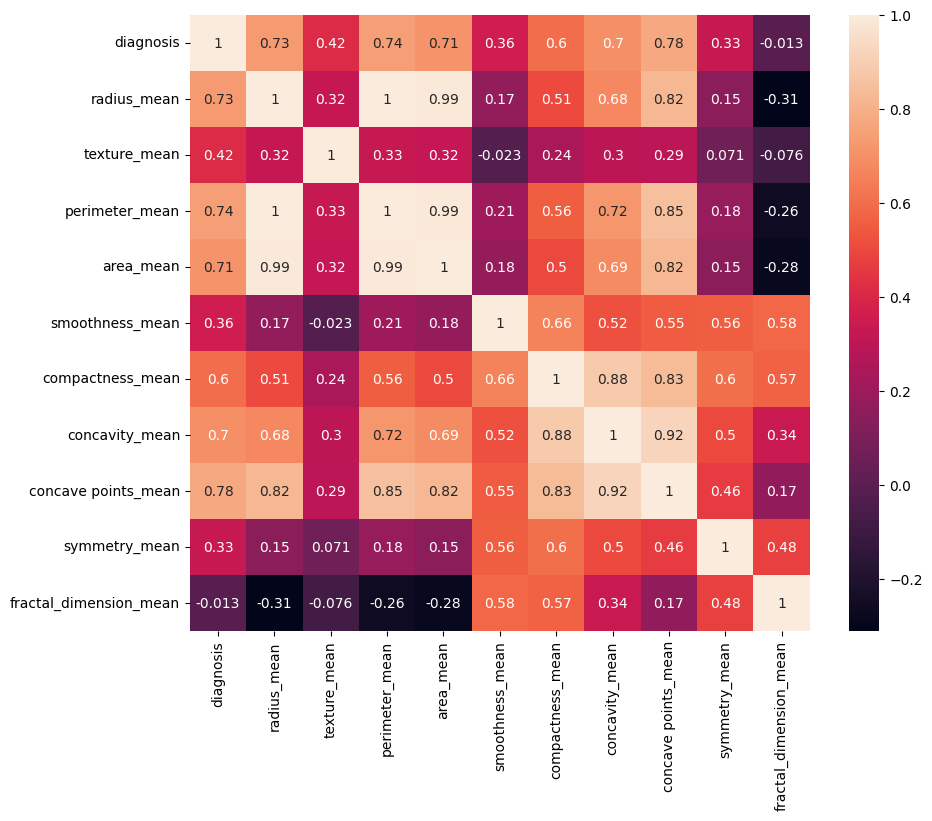

In [15]:
correlations = data[group_mean].corr()
sns.heatmap( correlations,  annot = True )
plt.gcf().set_size_inches(10, 8)

Most of the columns have positive values. Those below +0.5 are named: "texture_mean", "smoothness_mean", "symmetry_mean", "fractal_dimension_mean". This means models, built on this data would use data from 6/9 columns.

##### Second comes the "standard error" data:

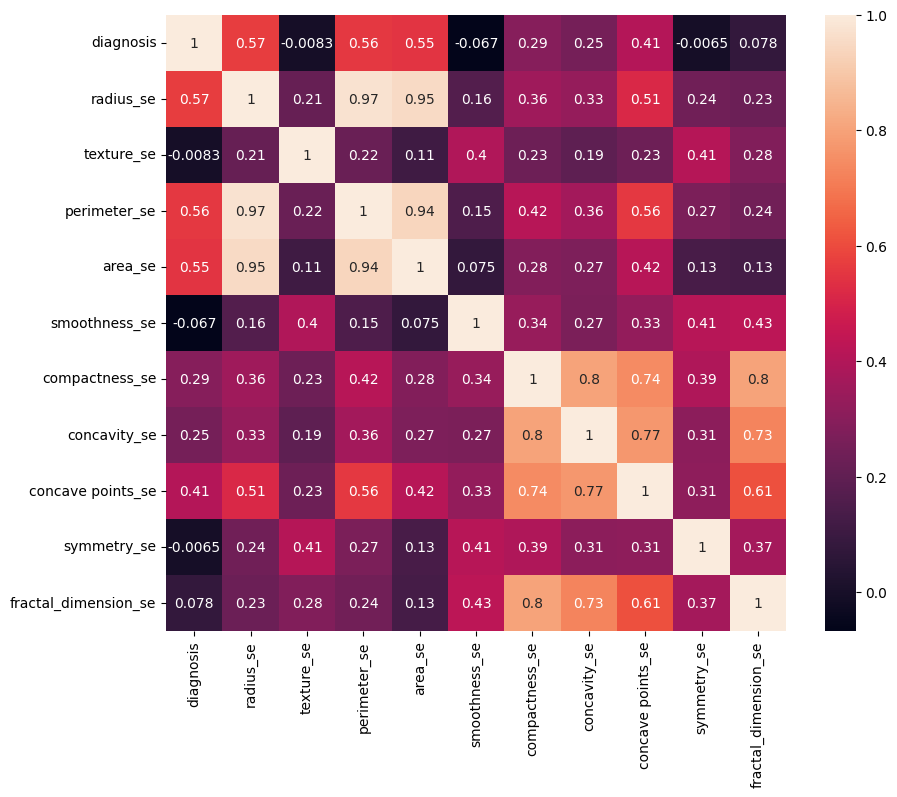

In [16]:
correlations = data[group_se].corr()
sns.heatmap( correlations,  annot = True )
plt.gcf().set_size_inches(10, 8)

Most of the columns have positive values. Those below +0.5 are named: "texture_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se". This means models, built on this data would use data from 3/9 columns.

##### Last comes the "largest" data:

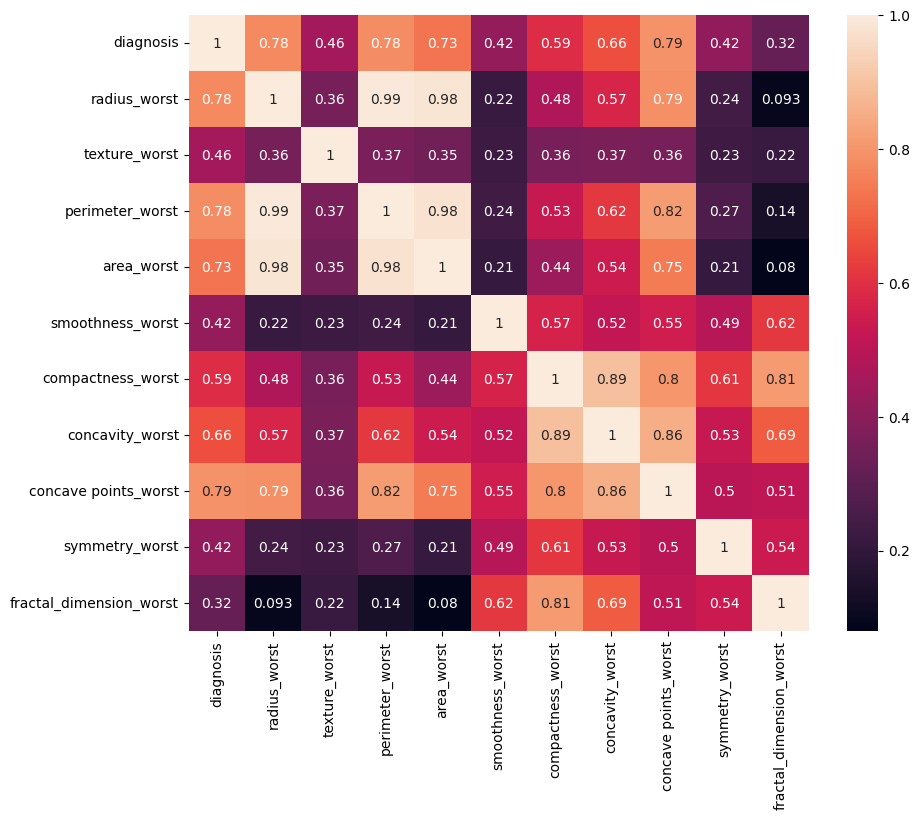

In [17]:
correlations = data[group_worst].corr()
sns.heatmap( correlations,  annot = True )
plt.gcf().set_size_inches(10, 8)

All of the columns have a positive value. Those below +0.5 are named: "texture_worst", "smoothness_worst", "symmetry_worst", "fractal_dimension_worst". This means models, built on this data would use data from 6/9 columns.

**Conclusion :**

The first (mean data) and last (worst data) seem to be almost identical. There are small differences. However one is built only on the largest differences, which would make models less optimal. The better option for a data subset to model over - is the one with "mean" values. The above-mentioned columns will be removed and only those with correlation coefficient of 0.5 and above would be taken into consideration. The use of only one column (with the highest correlation) instead of the 6 selected could result in a better accuracy of the model, but such simplifications will not help the complex real-world problem.

Lets form the new subset :

In [18]:
manual_data = data[group_mean].drop(["texture_mean", "smoothness_mean", "symmetry_mean", "fractal_dimension_mean"], axis=1, inplace=False)
manual_data.columns

Index(['diagnosis', 'radius_mean', 'perimeter_mean', 'area_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean'],
      dtype='object')

A small change in the names should be done :

In [19]:
manual_data = manual_data.rename(columns = {'radius_mean'         : 'radius', 
                                            'perimeter_mean'      : 'perimeter',
                                            'area_mean'           : 'area',
                                            'compactness_mean'    : 'compactness', 
                                            'concavity_mean'      : 'concavity', 
                                            'concave points_mean' : 'concave_points'})

A new look at the deviations:

In [20]:
manual_data.describe()

,diagnosis,radius,perimeter,area,compactness,concavity,concave_points
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,91.969033,654.889104,0.104341,0.088799,0.048919
std,0.483918,3.524049,24.298981,351.914129,0.052813,0.079720,0.038803
min,0.000000,6.981000,43.790000,143.500000,0.019380,0.000000,0.000000
25%,0.000000,11.700000,75.170000,420.300000,0.064920,0.029560,0.020310
50%,0.000000,13.370000,86.240000,551.100000,0.092630,0.061540,0.033500
75%,1.000000,15.780000,104.100000,782.700000,0.130400,0.130700,0.074000
max,1.000000,28.110000,188.500000,2501.000000,0.345400,0.426800,0.201200


Lets look at some graphics to represent the distributions of the diagnosis across the correlations.
Malignant is colored in yellow and benign is colored in blue in the graphs below.

<Figure size 1200x1000 with 0 Axes>

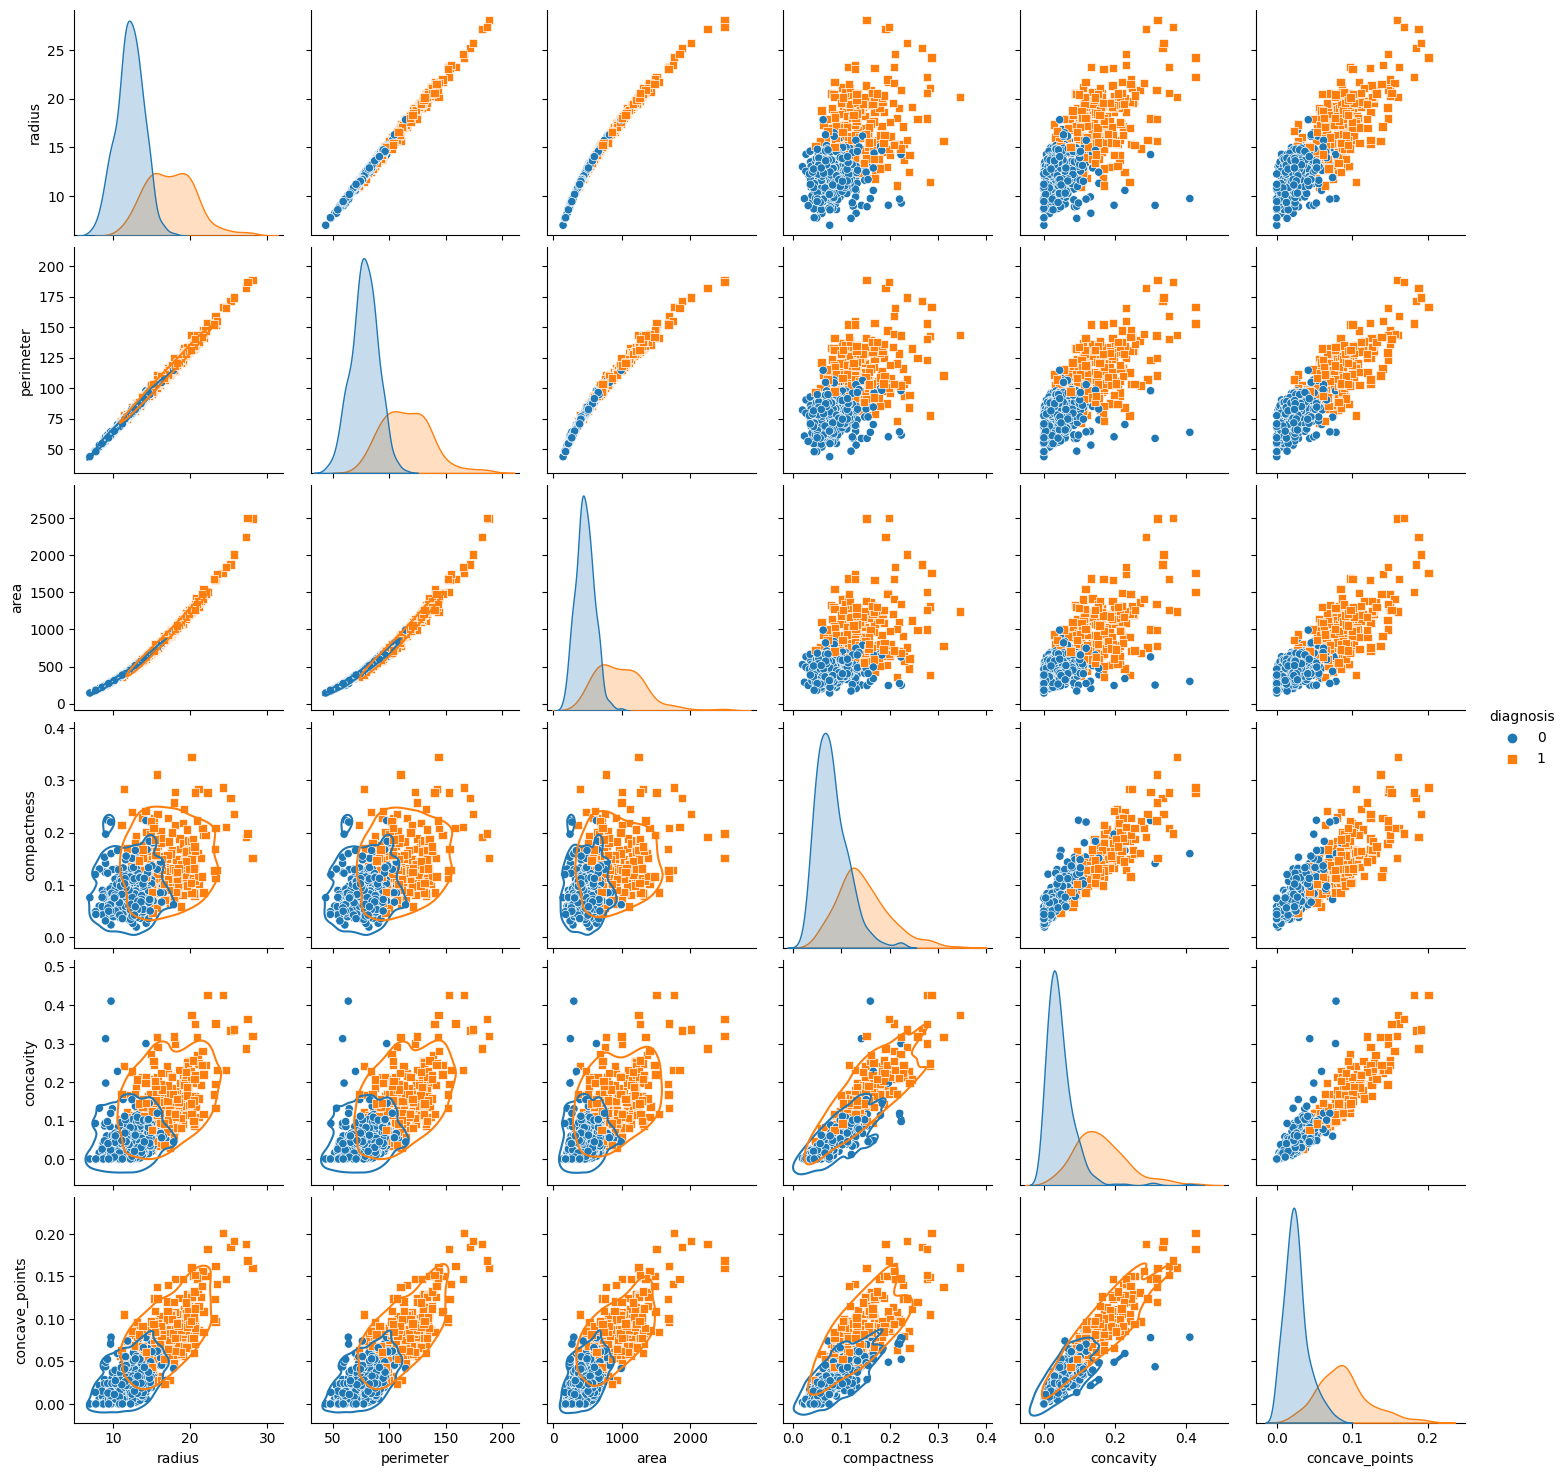

In [21]:
plt.figure(figsize = (12,10))

graphs = sns.pairplot(manual_data, hue='diagnosis', markers=["o", "s"])
graphs.map_lower(sns.kdeplot, levels=2, color="0.1")

After carrefully reducing the features by hand to 6/30 its time to try a different approach.

### 3.2 Use an algorithm to reduce the features
For the purposes of this project, lets use **PCA**. In order to uderstand how many of the features can be reduced, a **LogisticRegression** model will come in handy. It will be fitted over a training dataset and then its accuracy will be measured over a testing dataset. Afterwards we will start cutting down the (transformed by the PCA) features, until this accuracy starts changing.

#### 3.2.1 Split and scale the data
Since we are planning on using different models later on, its important to point out that some models that do better with ***MinMaxScaler*** than ***StandardScaler***, so lets do some min-max scaling. This tranformation will be fitted only to the training data, in order to simulate new data with the testing subset, which may get out of the [0;1] range.

The data should be seperated into a training and a testing set. Usually 80/20 is a good split, but since there are less than 600 rows, it would be better to use around 10% as test.

In [22]:
train_data, test_data = train_test_split(data, test_size = 0.1)

# Seperate the target from the variables :
target_train    = train_data['diagnosis']
variables_train = train_data.drop('diagnosis', axis=1, inplace=False)

target_test    = test_data['diagnosis']
variables_test = test_data.drop('diagnosis', axis=1, inplace=False)

A quick glance at the training variables :

In [23]:
variables_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
144,10.750,14.97,68.26,355.3,0.07793,0.05139,0.02251,0.007875,0.1399,0.05688,...,11.950,20.72,77.79,441.2,0.10760,0.12230,0.09755,0.03413,0.2300,0.06769
289,11.370,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.360,26.14,79.29,459.3,0.11180,0.09708,0.07529,0.06203,0.3267,0.06994
393,21.610,22.28,144.40,1407.0,0.11670,0.20870,0.28100,0.156200,0.2162,0.06606,...,26.230,28.74,172.00,2081.0,0.15020,0.57170,0.70530,0.24220,0.3828,0.10070
242,11.300,18.19,73.93,389.4,0.09592,0.13250,0.15480,0.028540,0.2054,0.07669,...,12.580,27.96,87.16,472.9,0.13470,0.48480,0.74360,0.12180,0.3308,0.12970
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.028720,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,9.742,15.67,61.50,289.9,0.09037,0.04689,0.01103,0.014070,0.2081,0.06312,...,10.750,20.88,68.09,355.2,0.14670,0.09370,0.04043,0.05159,0.2841,0.08175
167,16.780,18.80,109.30,886.3,0.08865,0.09182,0.08422,0.065760,0.1893,0.05534,...,20.050,26.30,130.70,1260.0,0.11680,0.21190,0.23180,0.14740,0.2810,0.07228
171,13.430,19.63,85.84,565.4,0.09048,0.06288,0.05858,0.034380,0.1598,0.05671,...,17.980,29.87,116.60,993.6,0.14010,0.15460,0.26440,0.11600,0.2884,0.07371
382,12.050,22.72,78.75,447.8,0.06935,0.10730,0.07943,0.029780,0.1203,0.06659,...,12.570,28.71,87.36,488.4,0.08799,0.32140,0.29120,0.10920,0.2191,0.09349


In [24]:
scaler = MinMaxScaler()
scaler.fit(variables_train)

variables_train = pd.DataFrame(scaler.transform(variables_train), columns=variables_train.columns)
variables_test  = pd.DataFrame(scaler.transform(variables_test),  columns=variables_test.columns)

Lets have a look at the values of the transformed training data.

In [25]:
variables_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,0.337947,0.395858,0.332314,0.216924,0.393750,0.286984,0.206474,0.241261,0.377791,0.268337,...,0.295720,0.363726,0.281849,0.170495,0.405126,0.218369,0.217146,0.398006,0.262453,0.189064
std,0.167549,0.174319,0.168115,0.150698,0.126047,0.174719,0.184385,0.190078,0.137209,0.149468,...,0.172406,0.162622,0.166883,0.141161,0.152035,0.152147,0.167081,0.227082,0.122102,0.119694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222277,0.268361,0.215828,0.116575,0.300781,0.151899,0.069213,0.101131,0.282197,0.162068,...,0.180452,0.240738,0.167576,0.080804,0.300007,0.115100,0.092572,0.225776,0.183718,0.105274
50%,0.303800,0.377593,0.293138,0.173022,0.390313,0.249709,0.140429,0.165681,0.369444,0.243997,...,0.249377,0.358342,0.235296,0.123218,0.397411,0.177945,0.180072,0.348239,0.246698,0.163453
75%,0.417270,0.496680,0.417110,0.271103,0.476393,0.377954,0.307052,0.365109,0.452652,0.339195,...,0.385539,0.470549,0.372354,0.218320,0.496797,0.298687,0.307907,0.562609,0.319732,0.242670
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3.2.2 Feature reduction using PCA
Evaluation of feature reduction cost is an iterative process - a function will come in handy :

In [26]:
def evaluate_pca_with_model(model, number_of_features, train_data, test_data, show_plot=False, return_pca_and_accuracy=False, return_only_accuracy=False):
    pca = PCA(n_components=number_of_features)
    pca.fit(train_data)

    pca_train = pd.DataFrame(pca.transform(train_data), columns=['axis_' + str(i + 1) for i in range(number_of_features)])
    pca_test = pd.DataFrame(pca.transform(test_data), columns=['axis_' + str(i + 1) for i in range(number_of_features)])

    # Plot the variance
    if show_plot:
        plt.figure(figsize=(16, 10))
        sns.barplot(x=pca.explained_variance_ratio_, y=['axis_' + str(i + 1) for i in range(number_of_features)], orient='h', palette='husl')
        plt.xlim(0., 1.)
        plt.xlabel('Proportion of Variance in Original Data')
        plt.title('Principal Component Variance')
        plt.show()

    # Fit the model :
    model.fit(pca_train,target_train)

    # Make predictions on training set :
    predictions = model.predict(pca_train)

    # Calculate and print the accuracy in :
    accuracy = int(metrics.accuracy_score(predictions,target_train)*100000)/100000
    print(f"The accuracy of the model with {number_of_features} features is : {accuracy}")

    if return_pca_and_accuracy :
        return (pca, pca_train, pca_test, accuracy)
    elif return_only_accuracy :
        return accuracy
    return

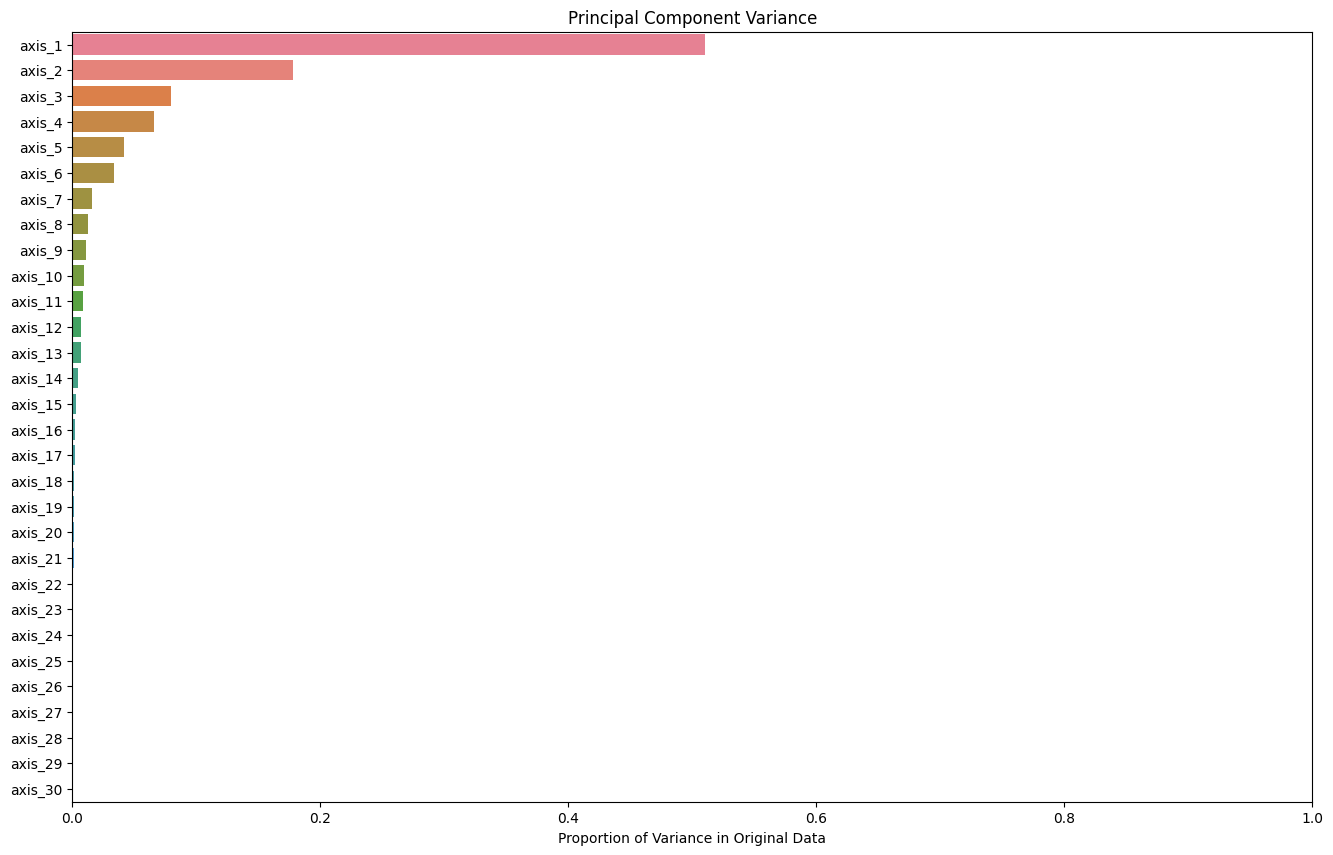

The accuracy of the model with 30 features is : 0.9746


In [27]:
num_features = variables_train.shape[1]

accuracy = evaluate_pca_with_model(LogisticRegression(), num_features, variables_train, variables_test, True, False, True)

Lets see what accuracy would the model score on different number of features :

In [28]:
for i in range (num_features, 0, -1) :
    evaluate_pca_with_model(LogisticRegression(), i, variables_train, variables_test, False, False, False)

The accuracy of the model with 30 features is : 0.9746
The accuracy of the model with 29 features is : 0.9746
The accuracy of the model with 28 features is : 0.9746
The accuracy of the model with 27 features is : 0.9746
The accuracy of the model with 26 features is : 0.9746
The accuracy of the model with 25 features is : 0.9746
The accuracy of the model with 24 features is : 0.9746
The accuracy of the model with 23 features is : 0.9746
The accuracy of the model with 22 features is : 0.9746
The accuracy of the model with 21 features is : 0.9746
The accuracy of the model with 20 features is : 0.9746
The accuracy of the model with 19 features is : 0.9746
The accuracy of the model with 18 features is : 0.9746
The accuracy of the model with 17 features is : 0.9746
The accuracy of the model with 16 features is : 0.9746
The accuracy of the model with 15 features is : 0.9746
The accuracy of the model with 14 features is : 0.9746
The accuracy of the model with 13 features is : 0.9746
The accura

It would be best to reduce the amount of features by a big amount and keep the accuracy relatively high. Small losses of accuracy for a big feature cut-out is a good trade-off, as it simplyfies the models afterwards. In this case 8 features seems good enough, even though 5 will also do.

In [29]:
num_features = 8
(pca, pca_train, pca_test, accuracy) = evaluate_pca_with_model(LogisticRegression(), num_features, variables_train, variables_test, False, True, False)

pca_train

The accuracy of the model with 8 features is : 0.9746


,axis_1,axis_2,axis_3,axis_4,axis_5,axis_6,axis_7,axis_8
0,-0.687905,-0.153192,-0.079241,0.033339,0.153391,-0.024092,0.016733,0.040272
1,-0.506344,0.019155,0.147249,0.183716,-0.167100,0.242434,-0.083836,-0.010042
2,1.344390,-0.018718,-0.113160,-0.101152,-0.054361,0.095874,0.015654,-0.092773
3,0.119300,0.658537,0.088302,-0.081636,0.314631,0.083326,0.091679,-0.049118
4,-0.327470,0.864129,-0.196602,0.509867,0.357335,-0.235547,0.347000,-0.057974
...,...,...,...,...,...,...,...,...
507,-0.634318,0.169449,-0.071001,0.039969,-0.193655,-0.089502,-0.048523,0.002412
508,0.208576,-0.294682,-0.026399,0.124036,-0.006828,0.076576,-0.078155,-0.015620
509,-0.112686,-0.224981,0.083766,-0.136512,-0.045940,-0.049237,-0.035192,0.086274
510,-0.220610,0.087624,0.259992,0.094872,0.496829,0.043082,0.036209,0.063597


Lets visualize the behaviour of the training data, as it may affect the choice of models used.

<Figure size 1200x1000 with 0 Axes>

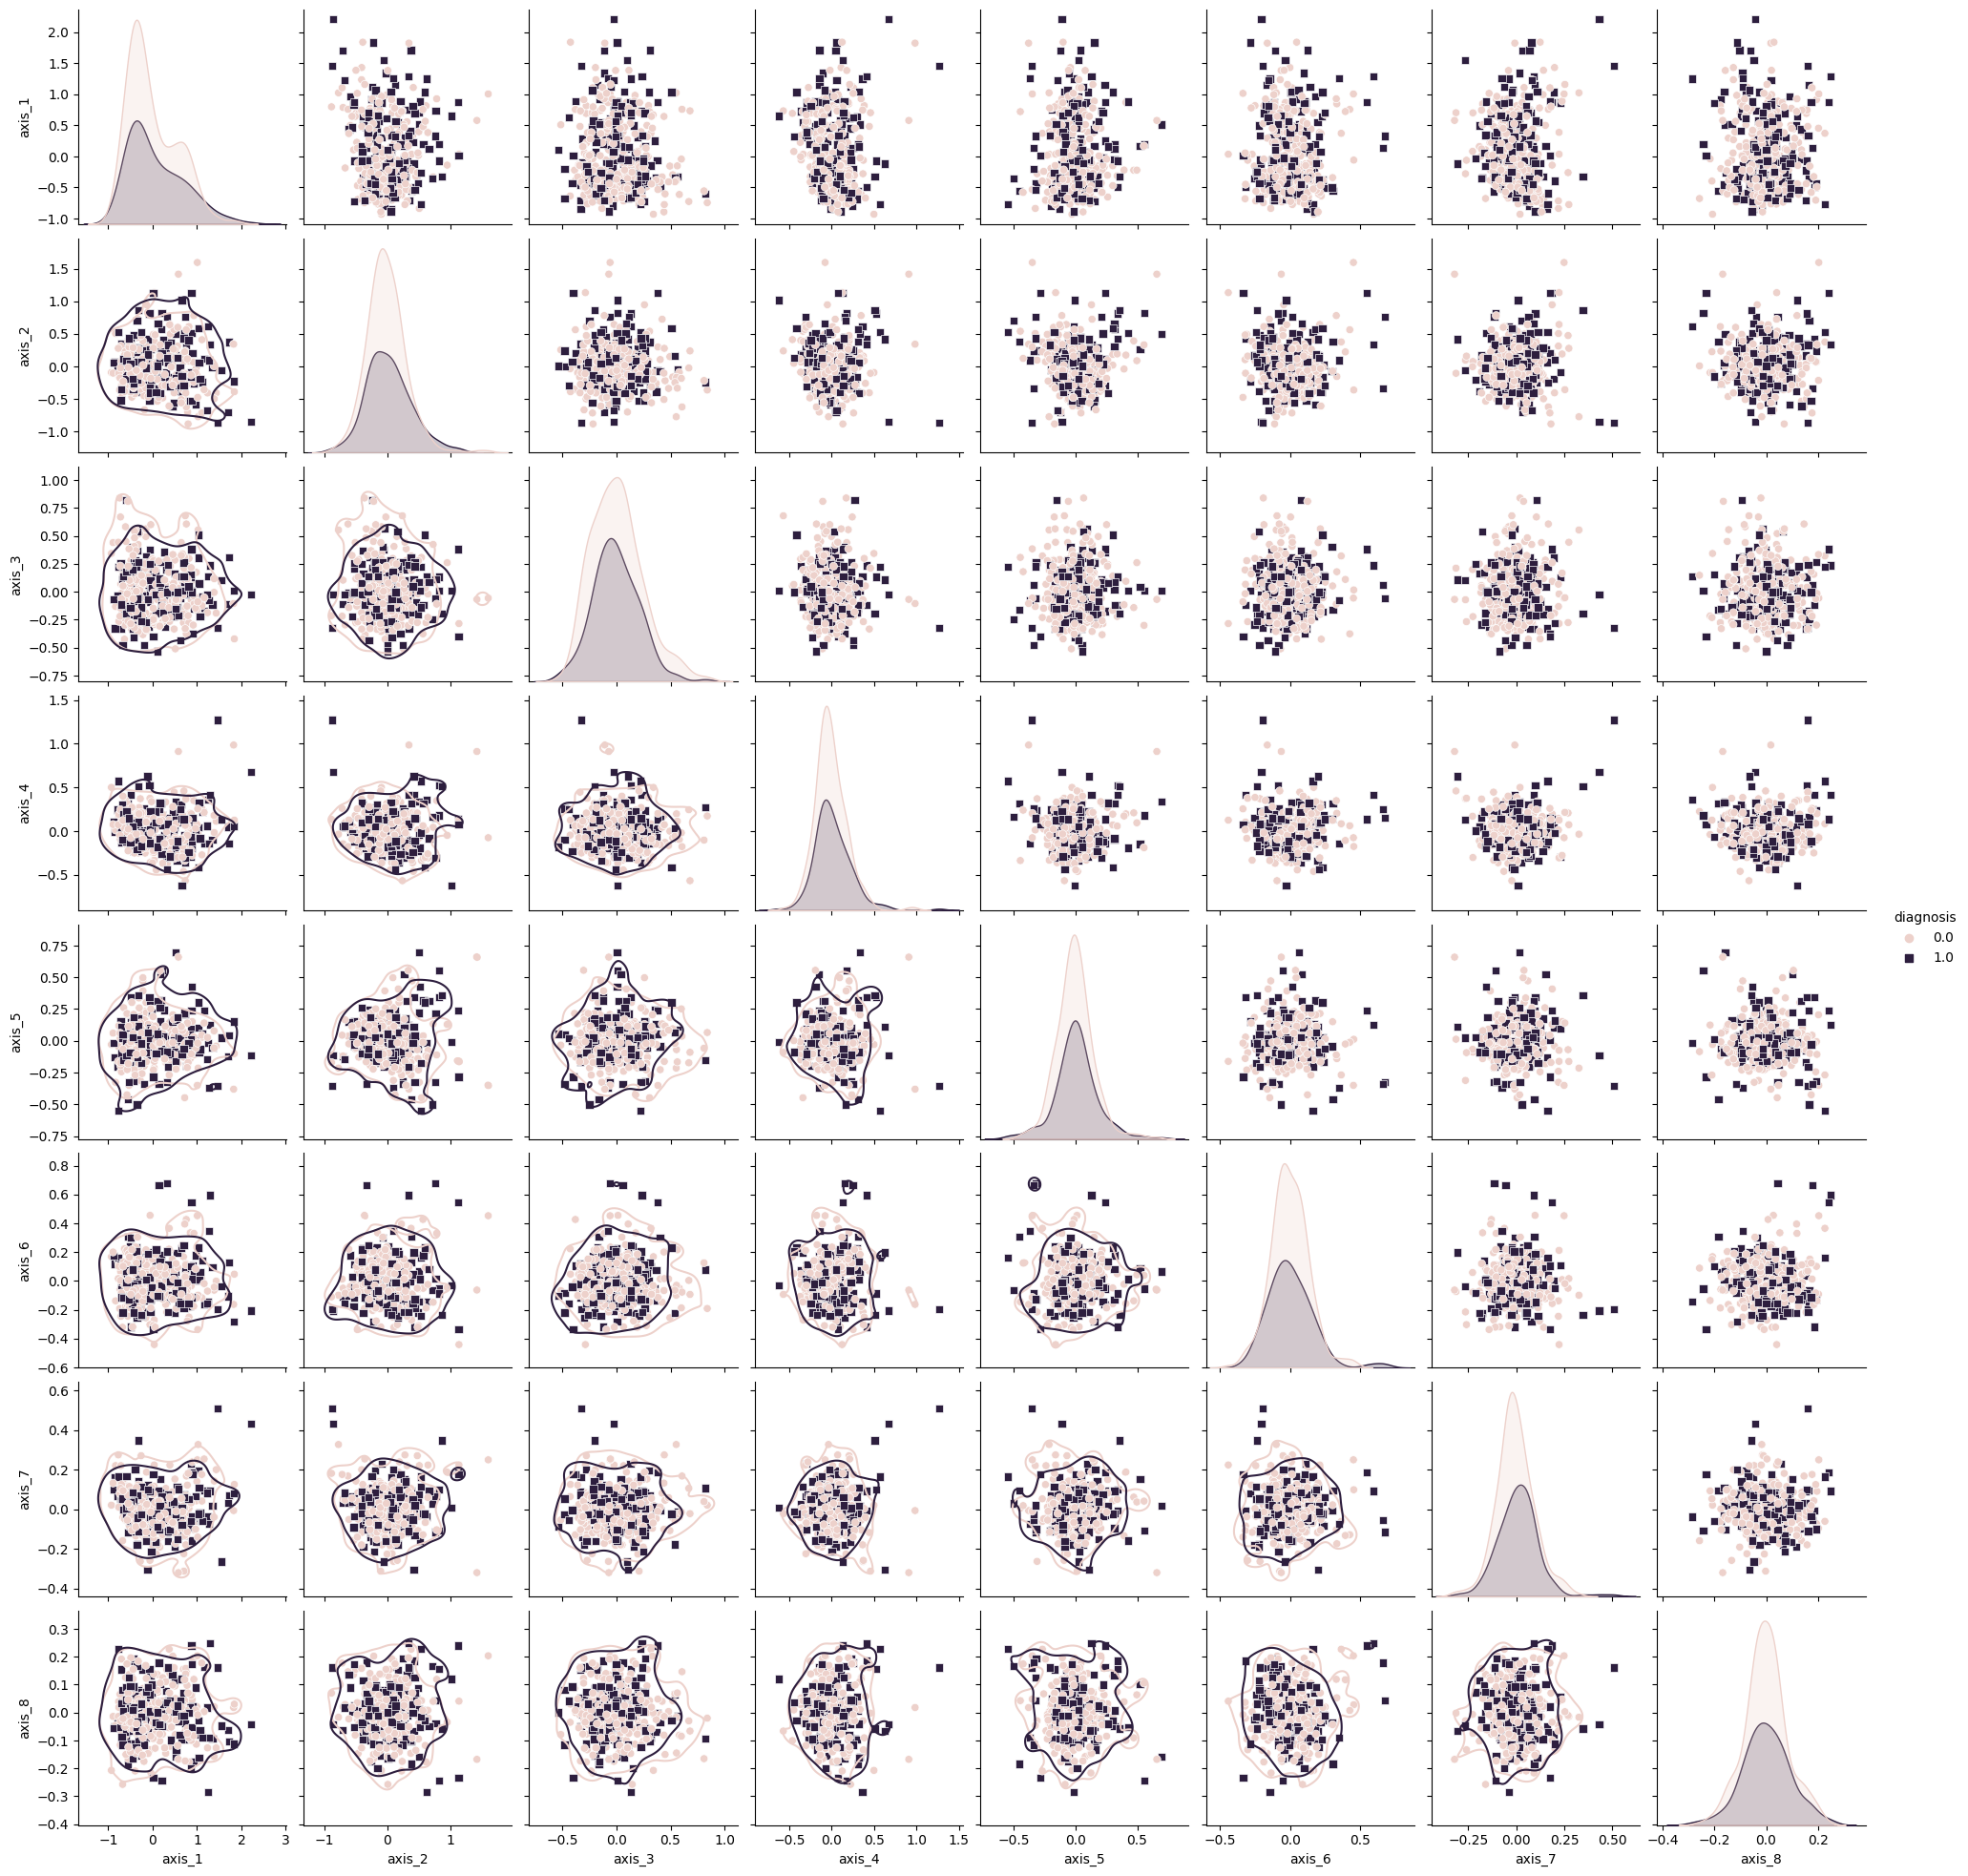

In [30]:
plt.figure(figsize = (12,10))

graphs = sns.pairplot(pd.concat([target_train, pca_train], axis=1), hue='diagnosis', markers=["o", "s"])
graphs.map_lower(sns.kdeplot, levels=2, color="0.1")

### 3.3 Compare features from 3.1 and 3.2

New datasets formed by both types of analysis are strongly correlated to the diagnosis, but the one done by hand uses 6/30 features (reduced by simple logic and 'feel'), whereas the one done by multidimensional transformation has 7/30 features, so some important info may be missing from the first dataset. Its only logical to continue with the results from the PCA analysis. However the dataset formed "by hand" could be used later for comparison.

<i><b>Note : </b>A combination of the two approaches is possible, but requires severe medical knowledge.</i>

As the data is tidy, ordered, filtered and has undergone feature reduction, its time to step into modelling.

## 4. Select, build and optimize models

The data was seperated into a training and a testing set with ratio 90/10, because of its short length - under 600 rows. To get a rough idea if the model is overfitting, the k-fold method will be implemented on the training set. It would be best if each fold has a size roughly the size of the testing data = 57.

Set the number of k-folds for the cross-validation : 

In [31]:
NUMBER_K_FOLDS = int(target_train.shape[0]/target_test.shape[0])
NUMBER_K_FOLDS

8

To cut down the repetition of code a function will come in handy :

In [32]:
def classifier_score(model, variables, target, training_or_testing, num_folds = 5):
    if target.shape[0] != variables.shape[0]:
        return "Wrong input - target and variables must have the same number of rows!"
    
    if training_or_testing not in ["training", "testing"]:
        return "Wrong input - mark the type of data input as 'training' or 'testing'!"

    # Fit the model :
    model.fit(variables,target)
    
    # Make predictions on training set :
    predictions = model.predict(variables)
    
    # Print accuracy :
    accuracy = metrics.accuracy_score(predictions,target)
    print(f"Accuracy of the {training_or_testing} dataset : %s" % "{0:.3%}".format(accuracy))
    
    cm = metrics.confusion_matrix(target, predictions, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    if training_or_testing  == "training":
      # Perform k-fold cross-validation with <num_folds> folds :
      kf = KFold(n_splits=num_folds, random_state=None, shuffle=True)
      error = []
      
      for train, test in kf.split(variables):
          # Filter training data :
          train_predictors = (variables.iloc[train,:])
          
          # The target we're using to train the algorithm :
          train_target = target.iloc[train]
          
          # Training the algorithm using the predictors and target :
          model.fit(train_predictors, train_target)
          
          # Record error from each cross-validation run :
          error.append(model.score(variables.iloc[test,:], target.iloc[test]))
      
          print(f"Cross-Validation Score of a fold of {training_or_testing} data : %s" % "{0:.3%}".format(np.mean(error)))
      
      # Fit the model again so that it can be refered outside the function :
      model.fit(variables,target)

**Classification models:**

***1. Naive Bayes***

***2. Logistic Regression***

***3. K-Nearest Neighbour***

***4. Random Forest Classifier***

***5. Support Vector Machines***

***6. Sequential Neural Network***

All will be optimized with the help of **GridSearchCV** and then compared.

**Notes :** 
- ***KMeans Clustering*** is not suitable for clusters which overlap such as this one, so it will not be used.
- ***Random Forest Classifier*** make the use of ***Decision Tree*** obsolete for this task, as a tree is known to easily overfit, which brings the need for a voting system between such models - hence the forest.

### 4.1 Naive Bayes

There are a few models, so lets have some info on which could be the best for the job :

- **Gaussian Naive Bayes:** gaussiannb is used in classification tasks and it assumes that feature values follow a gaussian distribution.

- **Multinomial Naive Bayes:** It is used for discrete counts. For example, let’s say,  we have a text classification problem. Here we can consider Bernoulli trials which is one step further and instead of “word occurring in the document”, we have “count how often word occurs in the document”, you can think of it as “number of times outcome number x_i is observed over the n trials”.

- **Bernoulli Naive Bayes:** The binomial model is useful if your feature vectors are boolean (i.e. zeros and ones). One application would be text classification with ‘bag of words’ model where the 1s & 0s are “word occurs in the document” and “word does not occur in the document” respectively.

- **Complement Naive Bayes:** It is an adaptation of Multinomial NB where the complement of each class is used to calculate the model weights. So, this is suitable for imbalanced data sets and often outperforms the MNB on text classification tasks.

- **Categorical Naive Bayes:** Categorical Naive Bayes is useful if the features are categorically distributed. We have to encode the categorical variable in the numeric format using the ordinal encoder for using this algorithm.

If you would like to see more info on the topic, click [here](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/).

It seems best to use the **Guassian Naive Bayes** classifier. Lets tune the hyperparameters with the help of **GridSearchCV**.

In [33]:
params_gnb = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GridSearchCV(estimator=GaussianNB(),
                   param_grid=params_gnb,
                   cv=NUMBER_K_FOLDS,
                   verbose=1,
                   scoring='accuracy')

gnb.fit(pca_train, target_train)

gnb.best_params_

Fitting 8 folds for each of 100 candidates, totalling 800 fits


{'var_smoothing': 0.02848035868435802}

Lets check the results on the train and test sets with tuned hyperparameters.

Accuracy of the training dataset : 93.945%


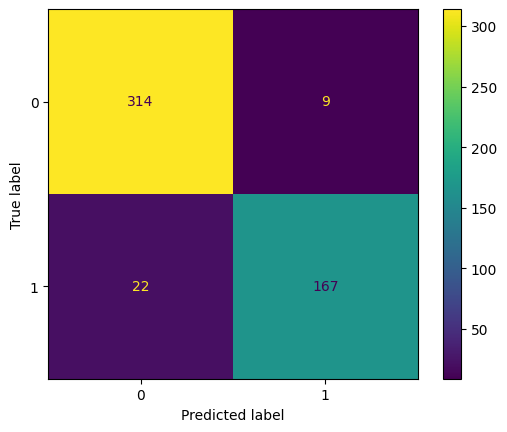

Cross-Validation Score of a fold of training data : 93.750%
Cross-Validation Score of a fold of training data : 95.312%
Cross-Validation Score of a fold of training data : 94.792%
Cross-Validation Score of a fold of training data : 93.750%
Cross-Validation Score of a fold of training data : 93.438%
Cross-Validation Score of a fold of training data : 93.490%
Cross-Validation Score of a fold of training data : 93.527%
Cross-Validation Score of a fold of training data : 93.359%

Accuracy of the testing dataset : 92.982%


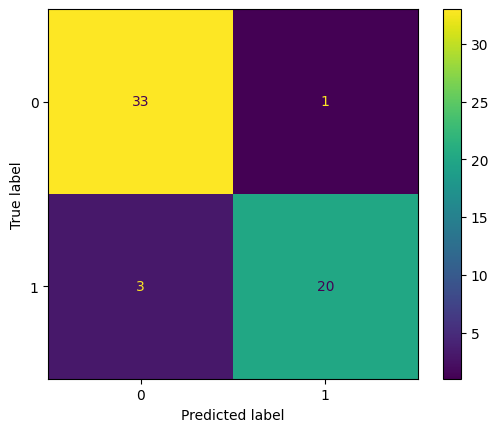

In [34]:
gnb = GaussianNB(var_smoothing=0.02848035868435802)
classifier_score(gnb, pca_train, target_train, 'training', NUMBER_K_FOLDS)
print()
classifier_score(gnb, pca_test,  target_test, 'testing')

**Conclusion :** Very high accuracy on both test and train data. Model seems stable and trustworthy.

### 4.2 Logistic Regression

Since there are too many paramteres that affect this classiefier, a quick check with [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) page, gives this important info:

- For small datasets, **liblinear** is a good choice, whereas **sag** and **saga** are faster for large ones;

- For multiclass problems, only **newton-cg**, **sag**, **saga** and **lbfgs** handle multinomial loss;

- **liblinear** is limited to one-versus-rest schemes;

- **newton-cholesky** is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.

The dataset is small (569 rows) and each fold will have small (less than 10) n_samples/n_features ratio, so **liblinear** solver will do. It support only ***l1*** and ***l2*** penalties so both of them will be given to **GridSearchCV**.

In [35]:
params_lr = {'solver':['liblinear'], 
             'penalty':['l1','l2'], 
             'C':np.logspace(-2,2,21), 
             'max_iter':np.array([50, 100, 150, 200, 250, 300])}

lr = GridSearchCV(estimator=LogisticRegression(),
                  param_grid=params_lr,
                  cv=NUMBER_K_FOLDS,
                  verbose=1,
                  scoring='accuracy')

lr.fit(pca_train, target_train)

lr.best_params_

Fitting 8 folds for each of 252 candidates, totalling 2016 fits


{'C': 3.981071705534973,
 'max_iter': 50,
 'penalty': 'l2',
 'solver': 'liblinear'}

Lets check the results on the train and test sets with tuned hyperparameters.

Accuracy of the training dataset : 97.852%


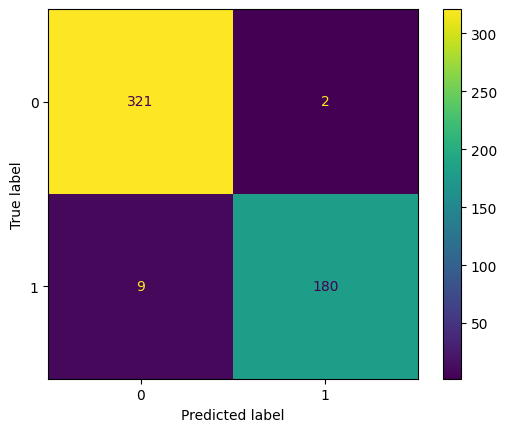

Cross-Validation Score of a fold of training data : 95.312%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 95.833%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 97.188%
Cross-Validation Score of a fold of training data : 97.135%
Cross-Validation Score of a fold of training data : 97.321%
Cross-Validation Score of a fold of training data : 97.461%

Accuracy of the testing dataset : 96.491%


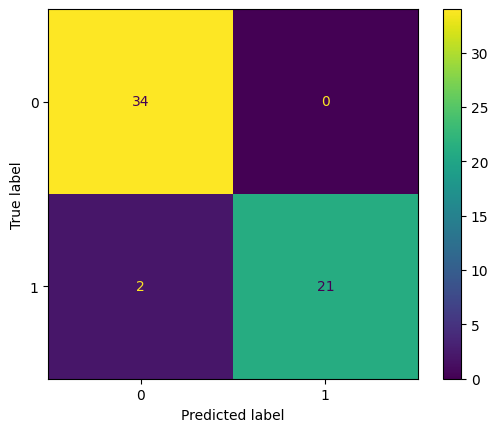

In [36]:
lr = LogisticRegression(penalty='l2', 
                        C=3.981071705534973, 
                        solver='liblinear',
                        max_iter=50)

classifier_score(lr, pca_train, target_train, 'training', NUMBER_K_FOLDS)
print()
classifier_score(lr, pca_test,  target_test, 'testing')

**Conclusion :** Even higher accuracy on both test and train data. Model seems stable and relevant. The regularization parameter **C** is bigger than the default value = 1, which means that there is some regularization of the data.

### 4.3 K-Nearest Neighbour

Tuning of the hyperparameters : 
- number of neighbours should be an odd number
- algorithm would be best to be set to 'auto', so it could adjust in the best way.

In [37]:
params_knn = {'n_neighbors':np.array([3,5,7,9]), 
              'weights':['uniform', 'distance'], 
              'algorithm':['auto']}

knn = GridSearchCV(estimator=KNeighborsClassifier(),
                   param_grid=params_knn,
                   cv=NUMBER_K_FOLDS,
                   verbose=1,
                   scoring='accuracy')

knn.fit(pca_train, target_train)

knn.best_params_

Fitting 8 folds for each of 8 candidates, totalling 64 fits


{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}

Lets check the results on the train and test sets with tuned hyperparameters.

Accuracy of the training dataset : 97.852%


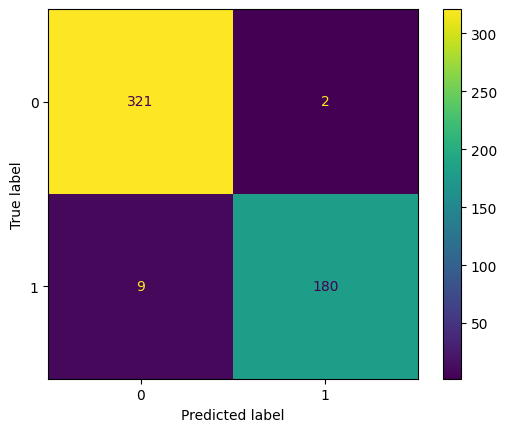

Cross-Validation Score of a fold of training data : 100.000%
Cross-Validation Score of a fold of training data : 98.438%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.615%
Cross-Validation Score of a fold of training data : 97.098%
Cross-Validation Score of a fold of training data : 96.875%

Accuracy of the testing dataset : 94.737%


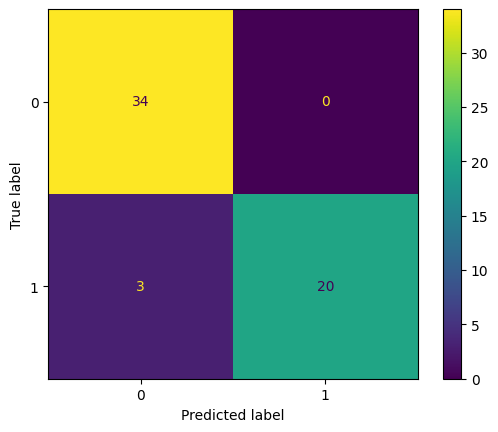

In [38]:
knn = KNeighborsClassifier(n_neighbors=5, 
                           weights='uniform', 
                           algorithm='auto')

classifier_score(knn, pca_train, target_train, 'training', NUMBER_K_FOLDS)
print()
classifier_score(knn, pca_test,  target_test, 'testing')

**Conclusion :** Very high accuracy on both test and train data. The model seems stable, but K-folds show overfitting.

### 4.4 Random Forest Classifier

The default values of the hyperparameters (found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) seem great for this dataset. In order to reduce the chance of overfitting, lets grow a forest of 200 trees and prune them all. The chosen hyperparameter values will be equal or less than the optimal ones.

In [39]:
params_rfc = {'n_estimators':np.array([200]), 
              'criterion':['entropy'],
              'max_depth':np.array([5, 6, 7, 8, 9, 10]),
              'max_leaf_nodes':np.array([3,4,5]),
              'max_features':['sqrt']}

rfc = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid=params_rfc,
                   cv=NUMBER_K_FOLDS,
                   verbose=1,
                   scoring='accuracy')

rfc.fit(pca_train, target_train)

rfc.best_params_

Fitting 8 folds for each of 18 candidates, totalling 144 fits


{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 5,
 'n_estimators': 200}

Lets check the results on the train and test sets with tuned hyperparameters.

Accuracy of the training dataset : 95.703%


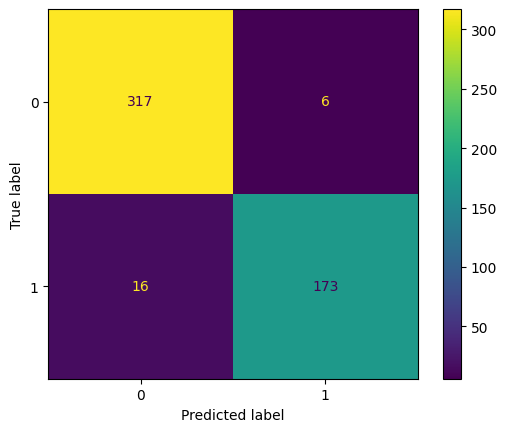

Cross-Validation Score of a fold of training data : 92.188%
Cross-Validation Score of a fold of training data : 93.750%
Cross-Validation Score of a fold of training data : 92.708%
Cross-Validation Score of a fold of training data : 92.969%
Cross-Validation Score of a fold of training data : 93.750%
Cross-Validation Score of a fold of training data : 94.531%
Cross-Validation Score of a fold of training data : 94.196%
Cross-Validation Score of a fold of training data : 94.531%

Accuracy of the testing dataset : 96.491%


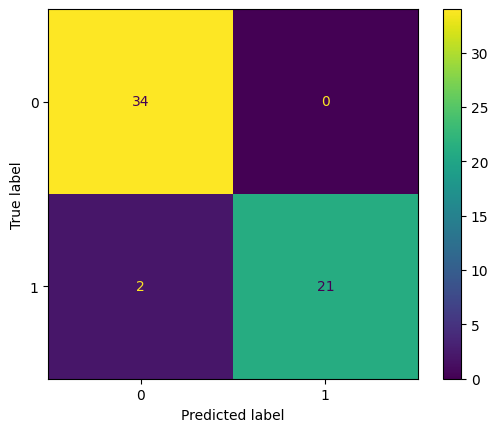

In [40]:
rfc = RandomForestClassifier(n_estimators=200, 
                             criterion='entropy',
                             max_depth=5,
                             max_leaf_nodes=3,
                             max_features='sqrt')

classifier_score(rfc, pca_train, target_train, 'training', NUMBER_K_FOLDS)
print()
classifier_score(rfc, pca_test,  target_test, 'testing')

**Conclusion :** After deliberately pruning the model, both results are very high. There probably is some overfitting (possibly more than the previous models), but stability seems to have be achieved.

### 4.5 Support Vector Machines

The default values of the hyperparameters (found [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) seem good enough for this dataset. However it is not clear which kernel should be used and what value should the regularization parameter ***C*** have.

In [41]:
params_svc = {'C':np.logspace(0,2,11),
              'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

svc = GridSearchCV(estimator=SVC(),
                   param_grid=params_svc,
                   cv=NUMBER_K_FOLDS,
                   verbose=1,
                   scoring='accuracy')

svc.fit(pca_train, target_train)

svc.best_params_

Fitting 8 folds for each of 44 candidates, totalling 352 fits


{'C': 1.5848931924611136, 'kernel': 'linear'}

Lets check the results on the train and test sets with tuned hyperparameters.

Accuracy of the training dataset : 97.656%


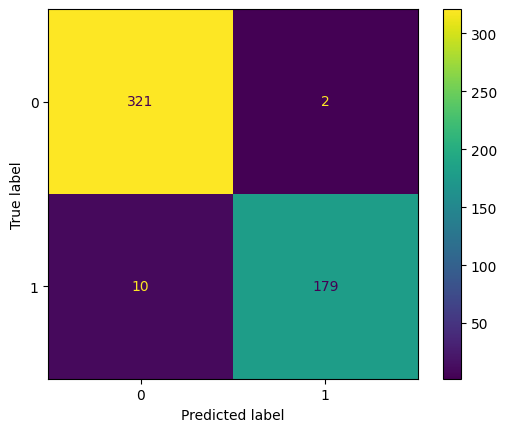

Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 96.484%
Cross-Validation Score of a fold of training data : 96.875%
Cross-Validation Score of a fold of training data : 97.135%
Cross-Validation Score of a fold of training data : 97.098%
Cross-Validation Score of a fold of training data : 97.266%

Accuracy of the testing dataset : 96.491%


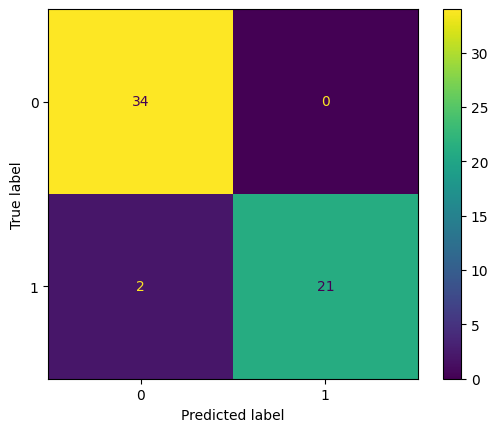

In [42]:
svc = SVC(C=1.5848931924611136, 
          kernel='linear')

classifier_score(svc, pca_train, target_train, 'training', NUMBER_K_FOLDS)
print()
classifier_score(svc, pca_test,  target_test, 'testing')

**Conclusion :** Incredibly high accuracy on both test and train data and stable behaviour. Model is trustworthy. The regularization parameter **C** is bigger than the default value = 1, which means that there is weak regularization of the data.

### 4.6 Sequential Neural Network
Given the small amount of data available it would be better for the network to have around 2-3 inner Dense layers. Some Dropout layers after the bigger Dense layers will come in handy. For activation function lets go with a simple yet trustworthy ***ReLU***. The activation on the last layer will be a Sigmoid funciton. The input depends on the **PCA** result. For optimizer we will use ***Adam*** and for loss function - ***Binary cross-entropy***.

In [43]:
nodes_first_layer = pca_train.shape[1]
print(f"Number of input nodes = {nodes_first_layer}")

Number of input nodes = 8


In [44]:
snn = Sequential([
                InputLayer((nodes_first_layer,), name='Input_Layer'),
                Dense(32, activation="relu", name='Hidden_Layer_1'),
                Dropout(0.1, name='Dropout_1'),
                Dense(16, activation="relu", name='Hidden_Layer_2'),
                Dropout(0.1, name='Dropout_2'),
                Dense(4, activation="relu", name='Hidden_Layer_3'),
                Dense(1, activation="sigmoid", name='Output_Layer'),
                ])

snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 32)                288       
                                                                 
 Dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 16)                528       
                                                                 
 Dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 Hidden_Layer_3 (Dense)      (None, 4)                 68        
                                                                 
 Output_Layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 889
Trainable params: 889
Non-trainable pa

In [45]:
LR = 1e-4
EPOCHS = 250
optim = Adam(learning_rate = LR, 
             weight_decay = LR / EPOCHS)

snn.compile(optimizer=optim, 
            loss=binary_crossentropy, 
            metrics=['accuracy'])

Lets take a look at the training process :

In [46]:
training = snn.fit(pca_train,
                  target_train,
                  epochs=EPOCHS,
                  batch_size = 32,
                  verbose=1,
                  validation_split = 1/NUMBER_K_FOLDS)

Epoch 1/250
14/14 [==============================] - 1s 17ms/step - loss: 0.7030 - accuracy: 0.4643 - val_loss: 0.7008 - val_accuracy: 0.4688
Epoch 2/250
14/14 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5246 - val_loss: 0.6994 - val_accuracy: 0.5156
Epoch 3/250
14/14 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5714 - val_loss: 0.6980 - val_accuracy: 0.5469
Epoch 4/250
14/14 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5893 - val_loss: 0.6966 - val_accuracy: 0.5625
Epoch 5/250
14/14 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.6049 - val_loss: 0.6953 - val_accuracy: 0.5781
Epoch 6/250
14/14 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.6183 - val_loss: 0.6939 - val_accuracy: 0.5781
Epoch 7/250
14/14 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.6272 - val_loss: 0.6925 - val_accuracy: 0.5781
Epoch 8/250


A visualization of the loss and accuracy per epoch will come in handy :

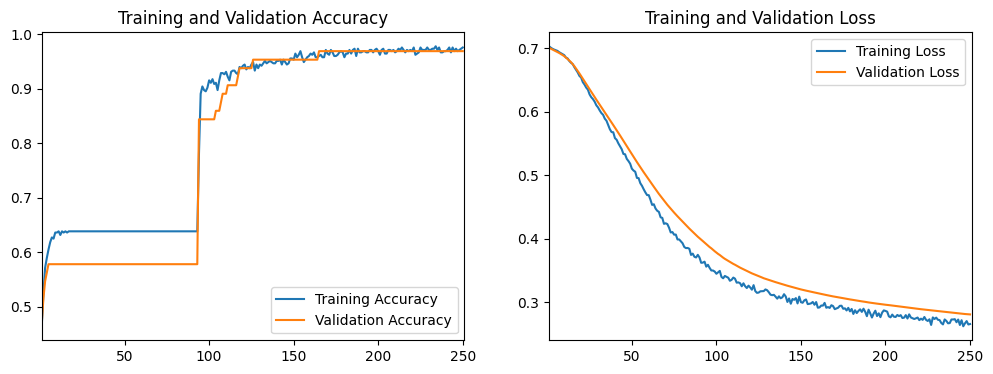

In [47]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()

Lets have a look at the accuracy of the model on both training and testing data :

16/16 [==============================] - 0s 1ms/step - loss: 0.2642 - accuracy: 0.9746
Accuracy on train dataset: 97.461%
16/16 [==============================] - 0s 1ms/step


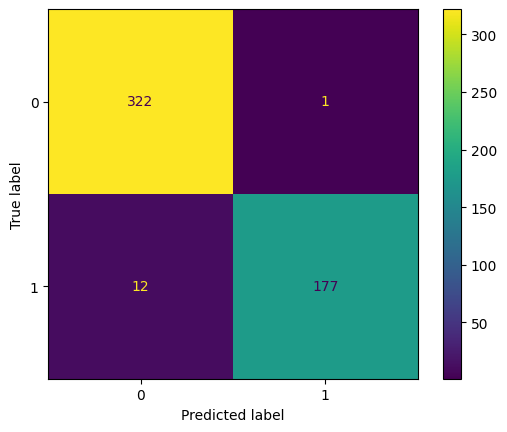

2/2 [==============================] - 0s 8ms/step - loss: 0.2708 - accuracy: 0.9825
Accuracy on test dataset: 98.246%
2/2 [==============================] - 0s 3ms/step


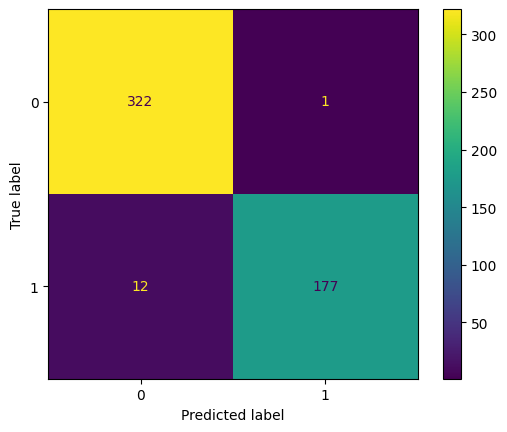

In [48]:
train_scores = snn.evaluate(pca_train, target_train)
print(f"Accuracy on train dataset: {train_scores[1]*100:.3f}%")
train_prediction = [np.round(x) for x in snn.predict(pca_train)]
cm_train = metrics.confusion_matrix(target_train, train_prediction)
disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.show()

test_scores = snn.evaluate(pca_test,  target_test)
print(f"Accuracy on test dataset: {test_scores[1]*100:.3f}%")
test_prediction =  [np.round(x) for x in snn.predict(pca_test)]
cm_test = metrics.confusion_matrix(target_train, train_prediction)
disp_test = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.show()

**Conclusion :** Incredibly high accuracy on both test and train datasets. Model seems to have converged. Looks stable.

## 5. Conclusion
It certainly is hard to say which model is the best, as all of them showed high scores. Some showed more unstable and overfitting results. ***Naive Bayes*** performance was great, but given the importance of the task, higher accuracy models should be taken into consideration. The ***Logistic Regression***, ***Support Vector Classifier*** and ***Sequential Neural Network*** showed the best stability and accuracy. For such small amounts of data it is easy to end up with some overfitting, which is why additional data should be gathered and the models should be reevaluated and retrained.